In [ ]:
# load dataset
from sklearn.datasets import fetch_california_housing
import pandas as pd

dataset = fetch_california_housing()

df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target

In [20]:
# Import library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Pisahkan fitur dan target
X = df.drop(columns=['target'])
y = df['target']

# Bagi data menjadi training dan validation set
# Menggunakan stratify=None karena ini masalah regresi
X_train, X_valid, y_train, y_valid = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

# Scaling data menggunakan RobustScaler untuk mengurangi efek outlier
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)  # Gunakan transform yang sama untuk data validasi

In [28]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
import numpy as np

def objective(trial):
    # Define hyperparameter search space
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    }

    # Initialize model with suggested hyperparameters
    model = XGBRegressor(
        **param,
        random_state=42,
        n_jobs=-1  # Use all available CPU cores
    )

    # Implement early stopping
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    # Make predictions
    preds = model.predict(X_valid)
    
    # Calculate multiple metrics
    r2 = r2_score(y_valid, preds)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    
    # Return R2 score as the optimization metric
    return r2  # Optuna akan mencari nilai tertinggi dari accuracy ini


In [29]:
study = optuna.create_study(direction="maximize")  # Karena kita mau cari accuracy tertinggi
study.optimize(objective, n_trials=50)

print('\nbest paramss: ',study.best_params)
print('best accuracy: ',study.best_value)


[I 2025-03-23 12:12:16,930] A new study created in memory with name: no-name-759fe2dd-2ab9-458f-b5c3-3302844a5a74
[I 2025-03-23 12:12:17,288] Trial 0 finished with value: 0.8300217467371723 and parameters: {'n_estimators': 380, 'learning_rate': 0.2267984524654778, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7612441729320708, 'colsample_bytree': 0.7231200329859802, 'reg_alpha': 0.03540787785376503, 'reg_lambda': 5.5124291970318036e-05, 'gamma': 8.140706227712132e-08}. Best is trial 0 with value: 0.8300217467371723.
[I 2025-03-23 12:12:18,434] Trial 1 finished with value: 0.8479007058210397 and parameters: {'n_estimators': 318, 'learning_rate': 0.029276520280412572, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.8198988005064682, 'colsample_bytree': 0.7286358653687417, 'reg_alpha': 1.0175706717393668e-08, 'reg_lambda': 0.0008872988504278354, 'gamma': 0.03300136133917135}. Best is trial 1 with value: 0.8479007058210397.
[I 2025-03-23 12:12:19,508] Trial 2 finished with v


best paramss:  {'n_estimators': 365, 'learning_rate': 0.03051821148203885, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.7579854071628466, 'colsample_bytree': 0.6775596150451884, 'reg_alpha': 0.004677711223336221, 'reg_lambda': 7.854726020909542e-08, 'gamma': 0.00019206133901896672}
best accuracy:  0.8524824087586055


In [30]:
# Get best parameters from Optuna study
best_params = study.best_trial.params

# Create XGBoost model with optimized parameters
best_model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'], 
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Train the model with early stopping
best_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=False
)

# Make predictions
y_pred = best_model.predict(X_valid)

# Evaluate model performance
r2 = r2_score(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

print('Model Performance Metrics:')
print(f'R² Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')


Model Performance Metrics:
R² Score: 0.8525
RMSE: 0.4397


c:\Users\formylife\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 1️⃣ Cek Overfitting atau Tidak

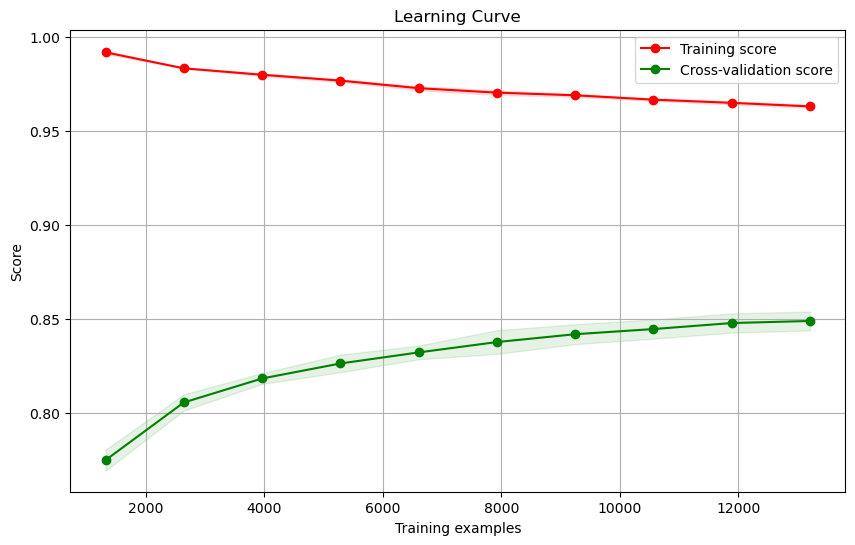

In [31]:
# learning curve berdasarkan training model

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()